In [0]:
!pwd

/content


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + "Object deletion/"

## Image segmentation with CamVid

In [0]:
doc(untar_data)

In [0]:
path = untar_data(URLs.CAMVID, dest = base_dir)
#path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/content/drive/My Drive/Object deletion/camvid/labels'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/codes.txt'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/valid.txt'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/images')]

In [0]:
path

PosixPath('/content/drive/My Drive/Object deletion/camvid')

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/My Drive/Object deletion/camvid/images/0006R0_f03420.png'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/images/0006R0_f03240.png'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/images/0016E5_02100.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/My Drive/Object deletion/camvid/labels/0016E5_07740_P.png'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/labels/0001TP_009690_P.png'),
 PosixPath('/content/drive/My Drive/Object deletion/camvid/labels/Seq05VD_f00750_P.png')]

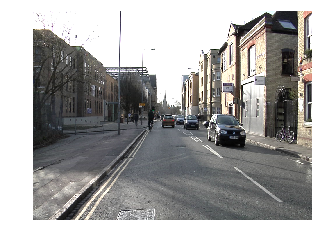

In [0]:
img = open_image(fnames[9])
img.show(figsize=(5,5))

Since labels contain extra "_P"

In [0]:
get_mask_filename = lambda mask_png: path_lbl/f'{mask_png.stem}_P{mask_png.suffix}'
mask_fname = get_mask_filename(fnames[9])
mask_fname

PosixPath('/content/drive/My Drive/Object deletion/camvid/labels/0016E5_01770_P.png')

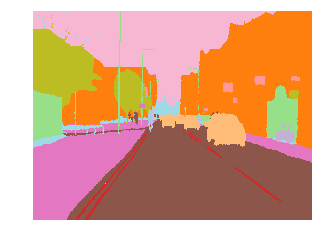

In [0]:
mask = open_mask(mask_fname)
mask.show(figsize=(5,5), alpha=1)

Size of a single image

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

## Datasets

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if   free > 15000:  bs = 14
elif free > 8200:   bs = 8
else:               bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=14, have 15068MB of GPU RAM free


In [0]:
codes = np.loadtxt(path/'codes.txt', dtype = str)
codes
size = src_size // 2

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_mask_filename, classes = codes))

In [0]:
type(src)

fastai.data_block.LabelLists

In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [0]:
type(data)

fastai.vision.data.ImageDataBunch

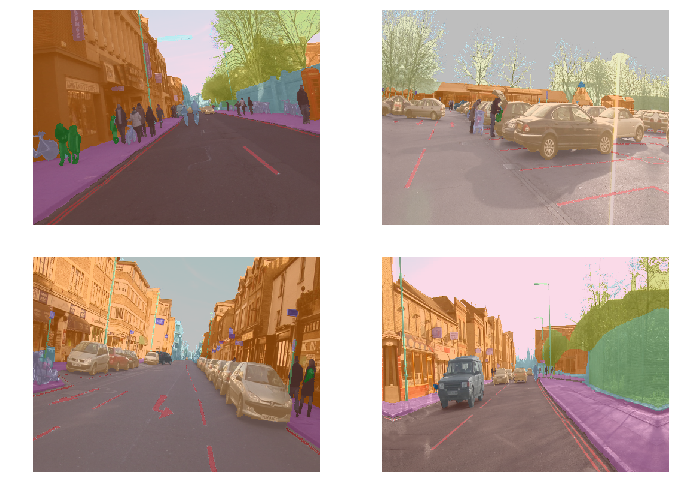

In [0]:
data.show_batch(2, figsize = (10,7))

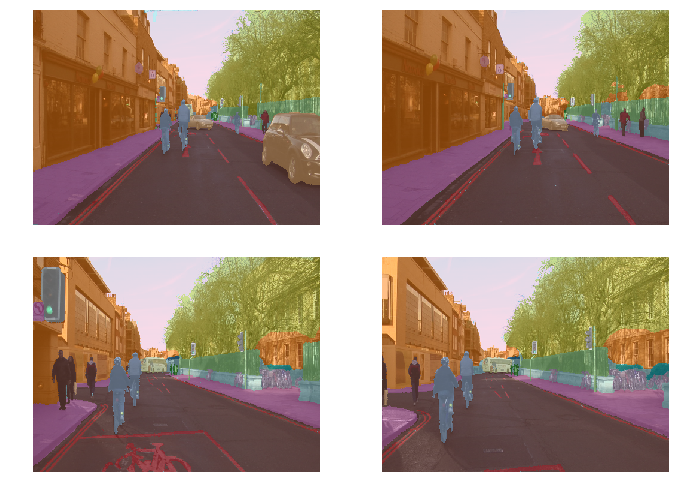

In [0]:
data.show_batch(2, figsize = (10,7), ds_type = DatasetType.Valid)

## Model

Custom accuracy metric

In [0]:
name2id = {value:key for key, value in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [0]:
metrics = acc_camvid
# metrics = accuracy

In [0]:
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)
#learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 168376110.68it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


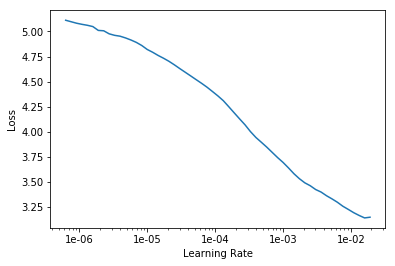

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = (3e-3)

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.9)

In [0]:
learn.save('1_first_Transfer')

In [0]:
learn.load('1_first_Transfer');

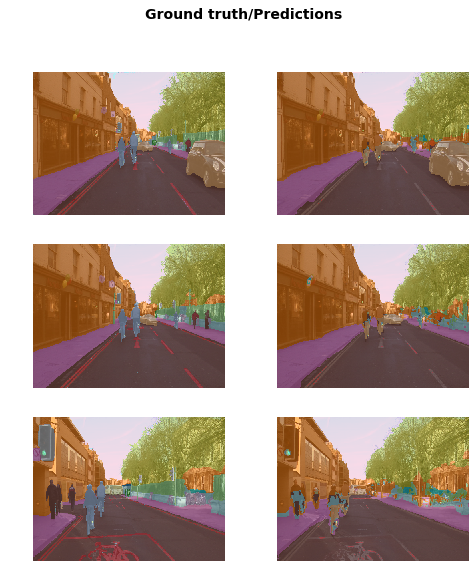

In [0]:
learn.show_results(rows = 3, figsize = (8,9))

In [0]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start = 0.8)

In [0]:
learn.save('2_Second_Transfer_Unfrozen')

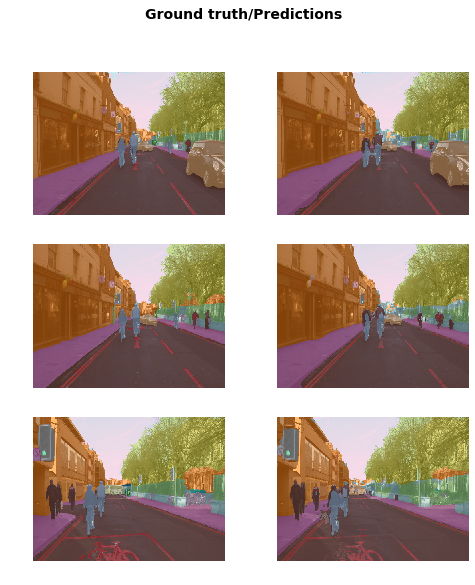

In [0]:
learn.show_results(rows = 3, figsize = (8,9))

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
!nvidia-smi

Wed Sep 11 04:24:29 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |  14441MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!ps -aux|grep python

root          23  0.2  0.8 413156 110072 ?       Sl   03:03   0:11 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root        2402 13.4 27.5 25903072 3678868 ?    Ssl  04:21   0:24 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-4eec06f0-a2f9-4160-84cb-0da9a2e248a4.json
root        2490  0.0  0.0  39192  6592 ?        S    04:24   0:00 /bin/bash -c ps -aux|grep python
root        2492  0.0  0.0  38572  5568 ?        S    04:24   0:00 grep python


In [0]:
!kill -9 2402

In [0]:
!nvidia-smi

Wed Sep 11 04:24:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Since we ended the process, Reloading the DataBunch

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


root_dir = "/content/drive/My Drive/"
base_dir = root_dir + "Object deletion/"


path = untar_data(URLs.CAMVID, dest = base_dir)

path_lbl = path/'labels'
path_img = path/'images'


fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)


get_mask_filename = lambda mask_png: path_lbl/f'{mask_png.stem}_P{mask_png.suffix}'


mask_fname = get_mask_filename(fnames[9])
mask = open_mask(mask_fname)


src_size = np.array(mask.shape[1:])

codes = np.loadtxt(path/'codes.txt', dtype=str)
size = src_size


src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_mask_filename, classes = codes))

# Error Metric:

name2id = {value:key for key, value in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()
  
metrics = acc_camvid


wd = 1e-2    # Weight Decay

In [0]:
#learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 15000:   bs = 3
elif free > 11000: bs = 2 
elif free > 8200:  bs = 2
else:              bs = 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 15068MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size = size, tfm_y = True)
        .databunch(bs = bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics = metrics, wd = wd)
#learn = unet_learner(data, models.resnet34, metrics=metrics, wd = wd).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 101333904.40it/s]


In [0]:
learn.load('2_Second_Transfer_Unfrozen');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


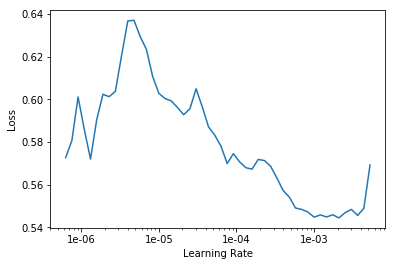

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 6e-4

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start = 0.8)

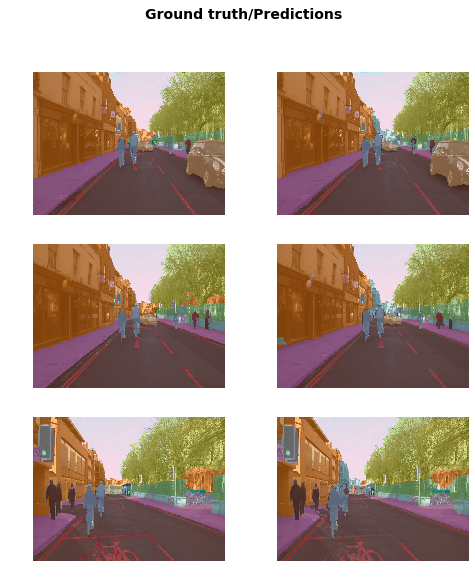

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.save('1_Frozen_big')

In [0]:
learn.load('1_Frozen_big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(4, lrs)

In [0]:
learn.save('2a_Unfrozen_big')

In [0]:
learn.load('2a_Unfrozen_big');

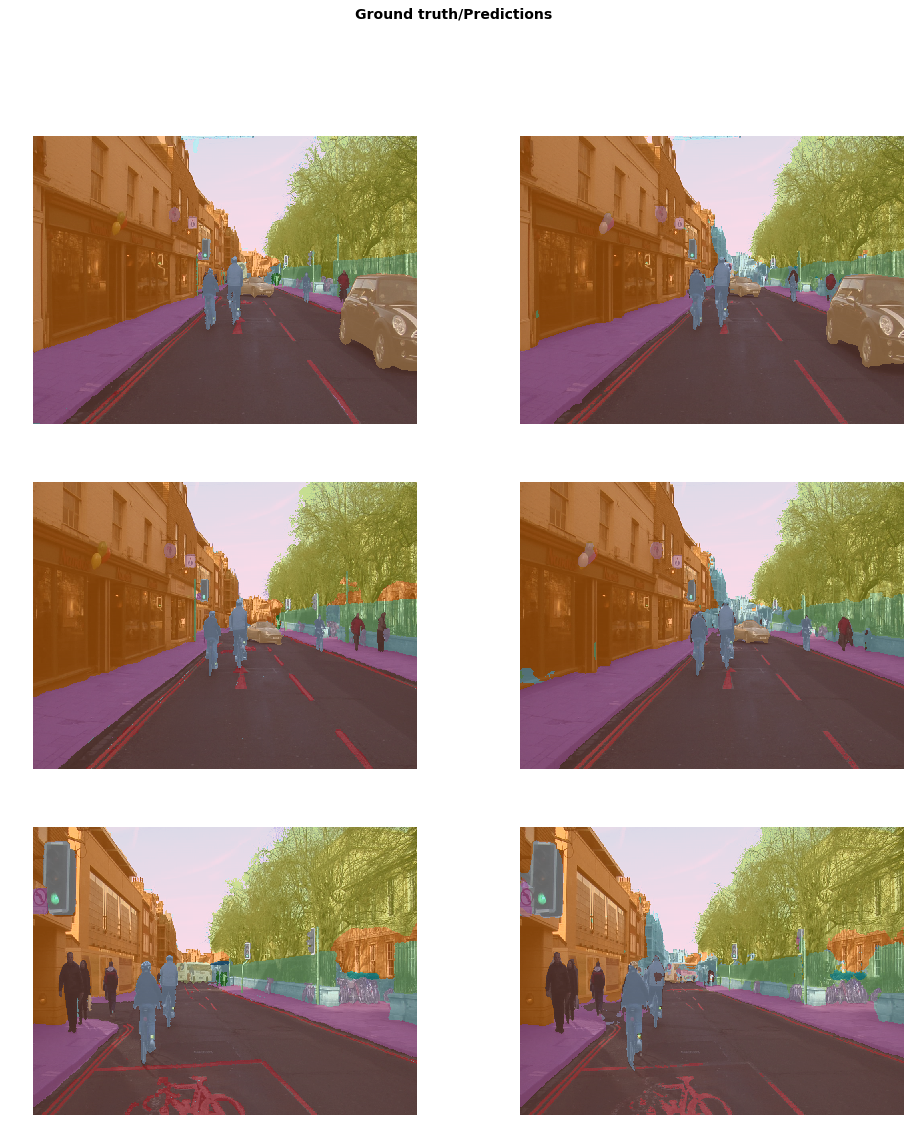

In [0]:
learn.show_results(rows = 3, figsize = (16,18))

In [0]:
learn.fit_one_cycle(8, lrs)

In [0]:
learn.save('final')

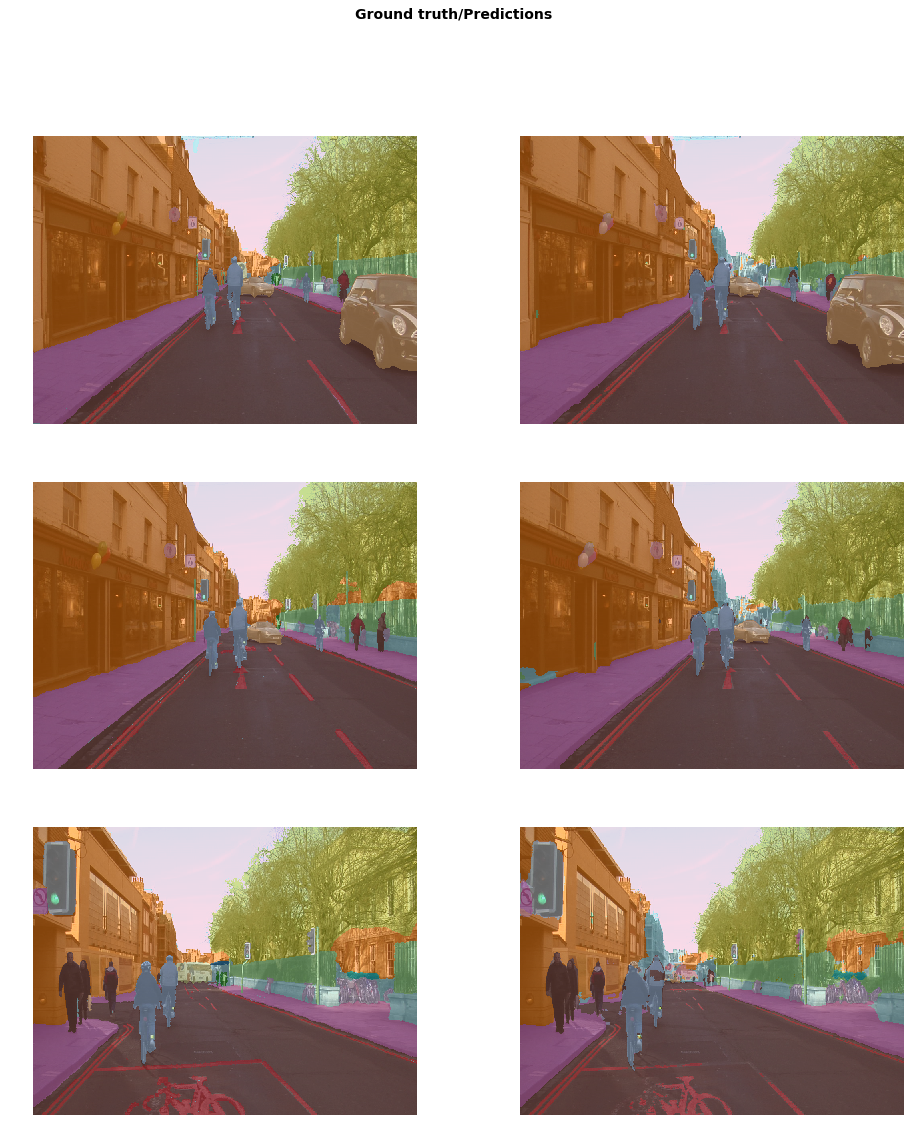

In [0]:
learn.show_results(rows = 3, figsize = (16,18))